In [1]:
cd /tf/astromer

/tf/astromer


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import sys,os

from core.data import load_records, load_records_v3

%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# ASTROMER input format

In [3]:
dataset = load_records('./data/records/alcock/train', 
                       batch_size=128, 
                       max_obs=200, 
                       msk_frac=0.5, 
                       rnd_frac=0.2, 
                       same_frac=0.2,
                       is_train=True)

Training Mode


In [4]:
for batch in dataset:
    
    for m, x in zip(batch['mask_out'], batch['length']):
        u = np.unique(m[:, 0].numpy())
        if len(u) == 1:
            print(x)
            break
    break

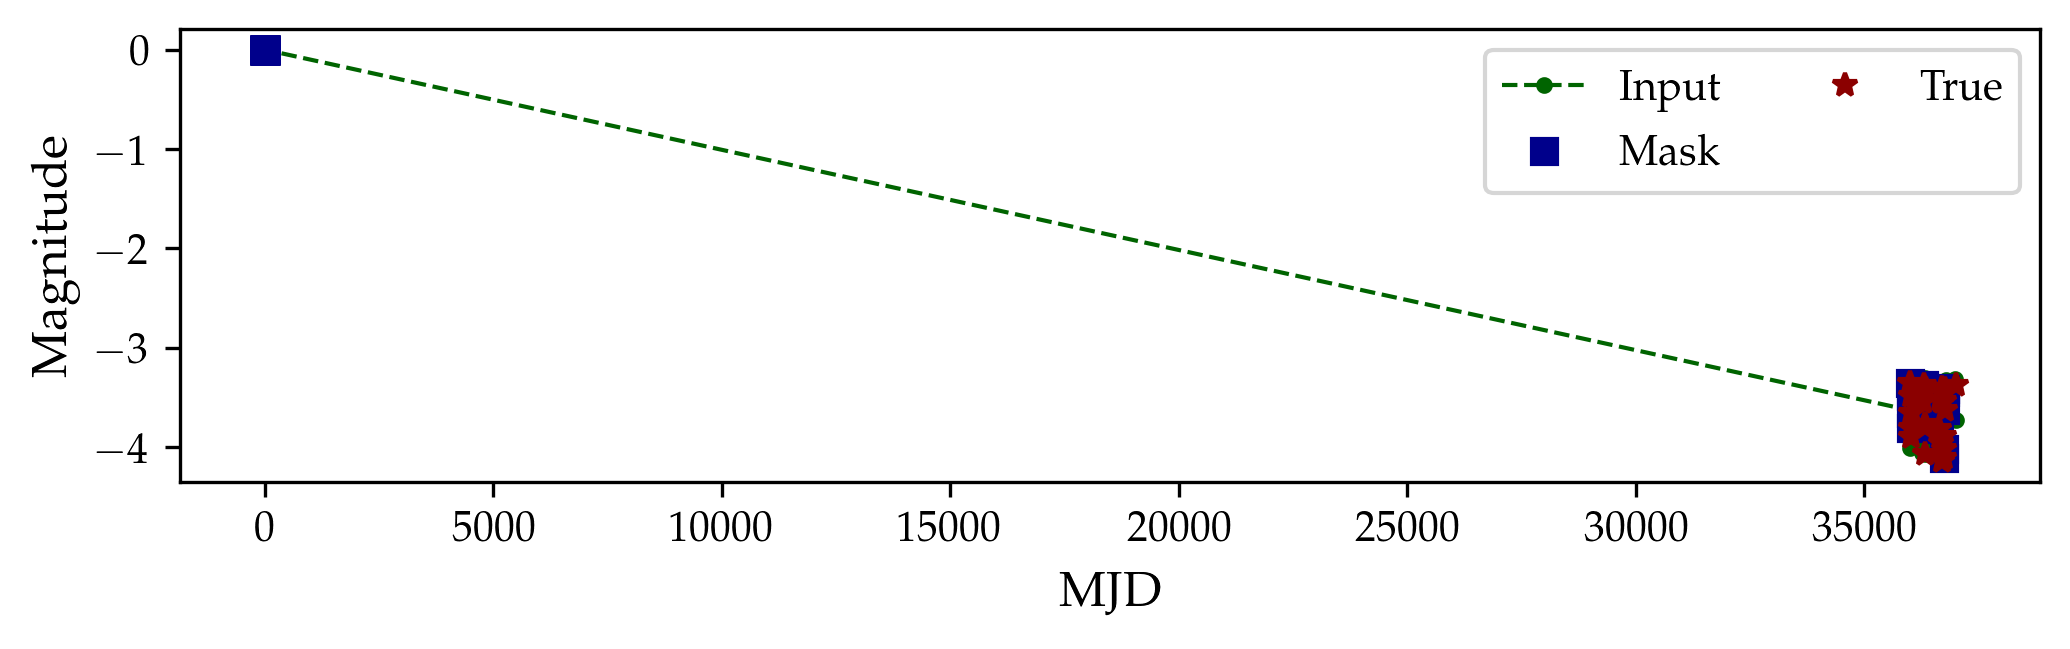

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(8,2), sharex=True, sharey=True, 
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, dpi=300)
for batch in dataset:

    x_input  = batch['input'][-1]
    x_output = batch['output'][-1]
    t_sample = batch['times'][-1]
    
    mask_in  = tf.squeeze(batch['mask_in'][-1])
    mask_out = tf.squeeze(batch['mask_out'][-1])
    

    times_masked = tf.boolean_mask(t_sample, mask_in)
    serie_masked = tf.boolean_mask(x_input, mask_in)

    times_masked_out = tf.boolean_mask(t_sample, mask_out)
    serie_masked_out = tf.boolean_mask(x_input, mask_out)
        
    axes.plot(t_sample, x_output, color='darkgreen', linestyle='--', marker='.', label='Input', linewidth=1)
    axes.plot(times_masked, serie_masked, marker='s', linestyle='', color='darkblue', label='Mask', linewidth=1)
    axes.plot(times_masked_out, serie_masked_out, color='darkred', linestyle='', marker='*', label='True', linewidth=1)

    axes.set_xlabel('MJD', fontsize=12)
    axes.set_ylabel('Magnitude', fontsize=12)    
    axes.legend(ncol=2, fontsize=10)#bbox_to_anchor=(0.1, 1.2), ncol=4)
    break
# fig.savefig('presentation/figures/input.png', transparent=True)
# fig.savefig('presentation/figures/input.pdf', format='pdf', bbox_inches='tight')

In [5]:
# fig.savefig('./presentation/figures/input.pdf', bbox_inches='tight', format='pdf')

# Classification input 

In [8]:
dataset = load_records_v3('./data/records/asas/train', batch_size=16, max_obs=200, is_train=True)

Training Mode


In [9]:
for batch, y in dataset:
#     print(batch['times'])
    break

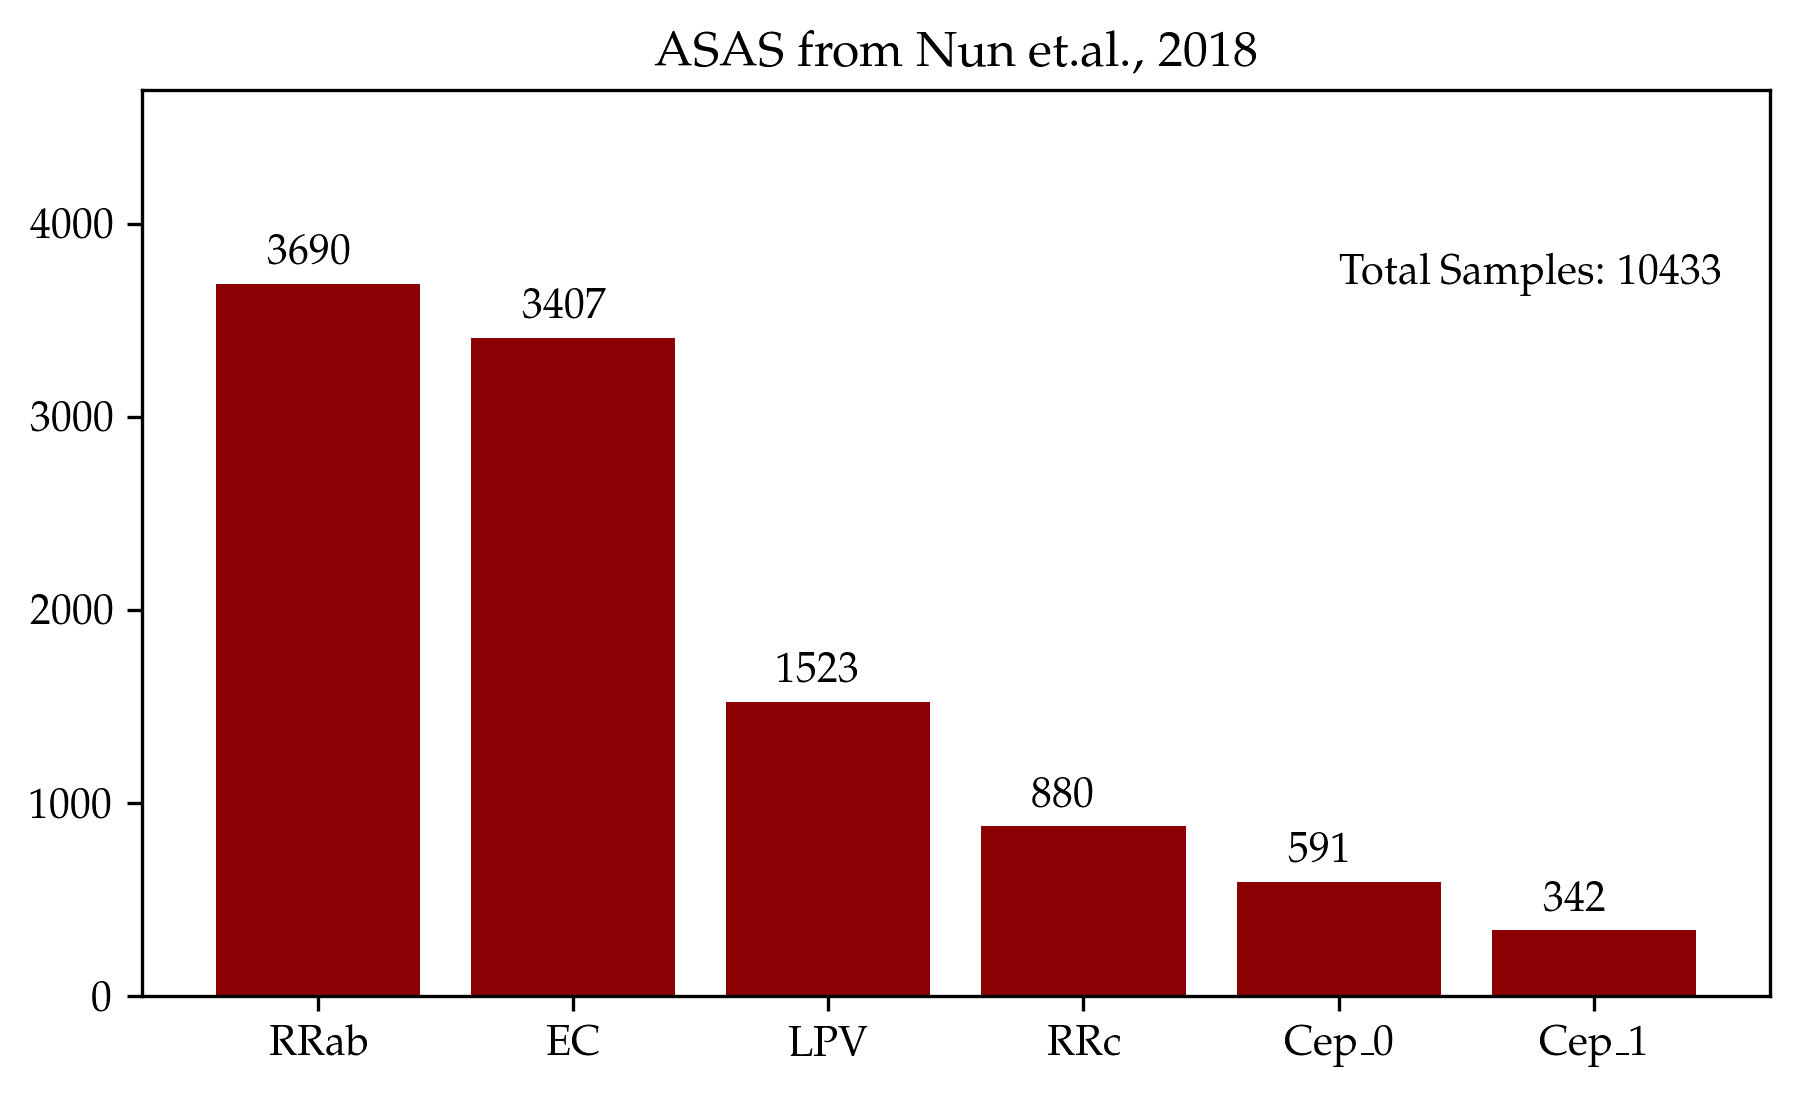

In [12]:
df_train = pd.read_csv('./data/records/alcock/train_objs.csv')
df_train = df_train['class'].value_counts().reset_index()

plt.figure(figsize=(7,4), dpi=300)
plt.bar(range(df_train.shape[0]), df_train['class'], color='darkred')

cls_names = df_train['index'].replace({'Cep_0': 'Cep\\_0', 
                                       'Cep_1': 'Cep\\_1'})
plt.title('ASAS from Nun et.al., 2018')
for i, val in enumerate(df_train['class']):

    plt.text(i-0.2, val+100, s='{}'.format(val))
    
plt.ylim(0, df_train['class'].max()+1000)
plt.xticks(range(df_train.shape[0]), cls_names)

plt.text(df_train['class'].shape[0]-2, 
         df_train['class'].max(), 
         s='Total Samples: {}'.format(df_train['class'].sum()))
plt.show()

In [18]:
df_labels = pd.read_csv('./data/records/alcock/test_objs.csv')
df_labels['class'].unique()

array(['Cep_0', 'Cep_1', 'EC', 'LPV', 'RRab', 'RRc'], dtype=object)

In [19]:
df_labels = pd.read_csv('./data/records/alcock/train_objs.csv')
class_names = np.unique(df_labels['class'].values)
class_names = [x.replace('_', '\_') for x in class_names]

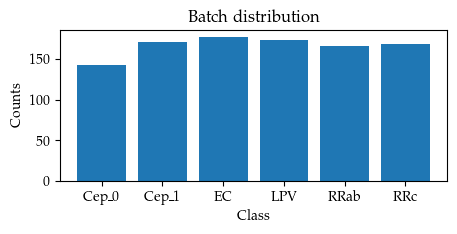

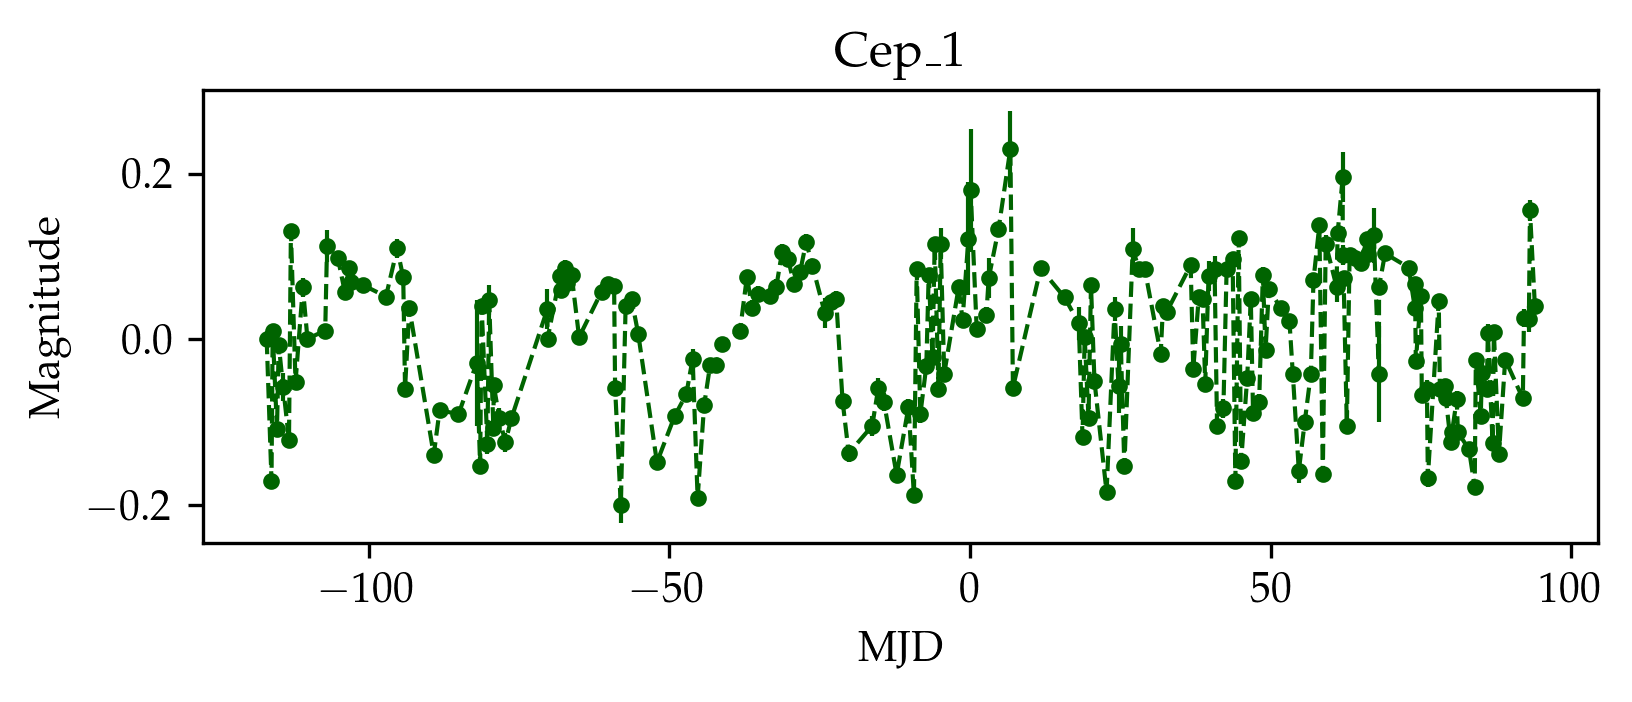

In [21]:
for batch in dataset:

    index = np.random.randint(0, batch['label'].shape)[0]
    e_sample = batch['obserr'][index]
    y_label  = batch['label'][index]
    x_input  = batch['input'][index]
    t_sample = batch['times'][index]
    
    mask_in  = 1.-tf.squeeze(batch['mask_in'][index])
    mask_out = 1.-tf.squeeze(batch['mask_out'][index])

    times_masked = tf.boolean_mask(t_sample, mask_in)[:, 0]
    serie_masked = tf.boolean_mask(x_input, mask_in)[:, 0]
    erros_masked = tf.boolean_mask(e_sample, mask_in)[:, 0]

    # BATCH DISTRIBUTION
    plt.figure(figsize=(5,2), dpi=100)
    batch_labels = batch['label'].numpy()
    uniques, counts = np.unique(batch_labels, return_counts=True)
    x = range(len(uniques))
    plt.bar(x, counts)
    plt.xticks(x, class_names[:len(uniques)])
    plt.title('Batch distribution')
    plt.xlabel('Class')
    plt.ylabel('Counts')
    plt.show()
    
    # Lightcurve
    fig, axes = plt.subplots(1, 1, figsize=(6,2), sharex=True, sharey=True, 
                             gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, dpi=300)
    axes.errorbar(times_masked, serie_masked, yerr=erros_masked, 
                  color='darkgreen', linestyle='--', marker='.', label='Input', linewidth=1)
    axes.set_title('{}'.format(str(class_names[y_label])))
    axes.set_xlabel('MJD')
    axes.set_ylabel('Magnitude')   
#     fig.savefig('presentation/figures/raw_input.png', transparent=True)
    plt.show()
    break